In [1]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf
import alchemy_tools2 as at

from matplotlib import pyplot as plt

In [2]:
# for every box size

    # load vasp file

    # for every radius
        # extract density
        # calculate integral for electrostatic interaction
        # store value of integral

In [3]:
def get_integrals_box(density, gpts, nuclei, radii):
    """
    return value of integrals for different vdW for one boxsize
    """
    estat_int = []
    for r in radii:
        estat_int.append( get_integral_radius(density, gpts, nuclei, r) )
    return(np.array(estat_int))
        
def get_integral_radius(density, gpts, nuclei, radius):
    """
    return value of integral for one multiple of the vdW radii
    """
    
    # set density to zero outside of integration radius
    density_bound = generate_bound_density(density, nuclei, radius, gpts)

    # calculate integral for new density
    estat_int = at.calculate_atomic_energies(density_extracted, nuclei, gpts, h_matrix)
    
    return(estat_int)
    
def generate_bound_density(density, nuclei, radius, gpts):
    # reshape into vectors
    density_flattened = density.flatten()
    gpts_flattened = at.meshgrid2vector(gpts)
    
    # get density grid points lying within the weighted vdW radii
    all_idc_in = get_all_idc_in(nuclei, radius, gpts_flattened)
    # get indices of all gridpoints as flattened 1D-array
    all_idc = np.arange(len(density_flattened))
     # get density grid points lying out of the weighted vdW radii
    all_idc_out = at.get_all_idc_out(all_idc_in, all_idc)
    
    # set density out of weighted vdW radii to zero
    density_flattened[all_idc_out] = 0.0
    # reshape flattened density to grid
    density_bound = density_flattened.reshape((density.shape))
    return(density_bound)
        
def get_all_idc_in(nuclei, radius, gpts_flattened):
    all_idc_in = []
    for n in nuclei:
        r_vdW = lookup_vdW(n[0])
        all_idc_in.append(at.get_idc_rvdW(np.array([n[1:4]]), r_vdW*radius, gpts_flattened))
    return(all_idc_in)
   
from ase.units import Bohr
def lookup_vdW(Z, unit = 'Bohr'):
    """
    return van der Waals radius for element
    from Bondi J. Phys. Chem 68, 1964
    """
    
    if Z == 1:
        r_w = 1.2
    elif Z == 6:
        r_w = 1.7
    elif Z == 7:
        r_w = 1.55
    elif Z == 8:
        r_w = 1.52
    else:
        raise Exception("r_w not implemented for Z = {}".format(Z))
        
    if unit == 'Bohr':
        r_w /= Bohr
    return(r_w)
    

In [4]:
boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_002626/cube-files/ve_8.cube']
# boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/test_calculations/vasp/dsgdb9nsd_001212/box20.0/CHG']
radii = [0.5, 1]
lam_vals, dens, nuclei, gpts, h_matrix = at.load_cube_data(boxes)
# for b in boxes:
#     dens, nuclei, gpts, h_matrix = at.load_vasp_dens([b])
#     estat_int = get_integrals_box(dens, gpts, nuclei, radii)

In [ ]:
estat_int = get_integrals_box(dens, gpts, nuclei, radii)

In [58]:
density_extracted = dens.flatten()
gpts_flattened = at.meshgrid2vector(gpts)

In [50]:
density_extracted.shape

(5359375,)

In [46]:
cextr = pdf.CUBE(boxes[0])

In [89]:
density_extracted = dens.flatten()
gpts_flattened = at.meshgrid2vector(gpts)
density_extracted = extract_density(density_extracted, nuclei, 2.0, gpts_flattened)
density_extracted = density_extracted.reshape(dens.shape)[0]

In [90]:
density_extracted.shape

(175, 175, 175)

In [91]:
cextr.data = density_extracted

In [92]:
cextr.data.shape

(175, 175, 175)

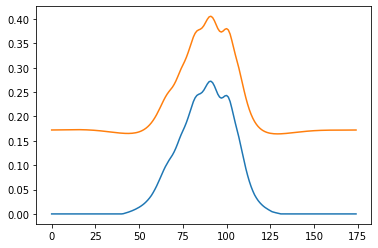

In [93]:
pr_ex = cextr.project((0,1))/cextr.dv
pr = dens[0].sum(axis=(0,1))
plt.plot(pr_ex)
plt.plot(pr)

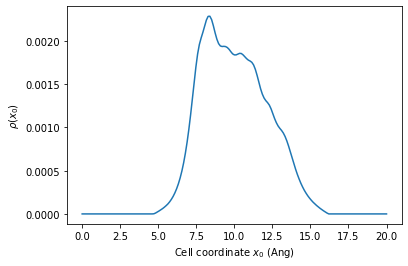

In [94]:
cextr.plot_projection((0,2))

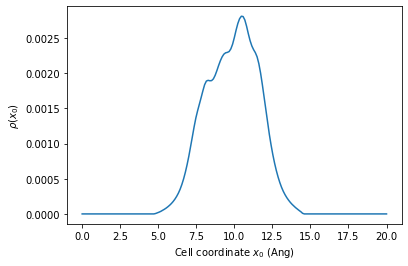

In [95]:
cextr.plot_projection((1,2))

# Implementation prototype

## Determine volume of bound electrons - density extraction

Preparation of data, such that only density in spheres around nuclei is used for calculation of atomic energies

strategy: set density out side of radii to zero, then these gridpoints do not contribute to the integral $\int d\vec{r} \frac{\tilde{\rho}}{|\vec{r}-\vec{R_I}|}$

this way after loading the density files; an additional step is carried out as implemented in this notebook
in this step the density array is changed as described above; then the atomic energies can be calculated as already implemented without any changes to the existing code

In [ ]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf

In [ ]:
def meshgrid2vector(grid):
    """
    convert components of meshgrid into set of vectors; every vector is a point of the grid
    e.g. a 3D grid is converted in a numpy array of shape (number gridpoints, 3)
    """
    flattened_grid = []
    for c in grid:
        flattened_grid.append(c.flatten())
        
    return(np.array(flattened_grid).T)
    

# get grid points lying in sphere with radius r_vdW

def get_idc_rvdW(center, rvdw, gpts):
    """
    returns indices of grid points lying in a sphere around center with radius rdwV
    
    center: center of sphere
    rdvw: radius of sphere
    coordinates of grid as flattened numpy array, shape (number of grid points, dimension of grid)
    """
    
    # distance of every gridpoint from center
    distance_array = scsp.distance.cdist(gpts, center)
    
    
    idc_in_sphere = np.where(distance_array[:, 0] <= rvdw)[0] # indices of points within sphere with vdW radius
    idc_out_sphere = np.where(distance_array[:, 0] > rvdw)[0] # indices of points out of sphere with vdW radius
    
    return(idc_in_sphere, idc_out_sphere)

In [ ]:
# load data

In [ ]:
path = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_002626/cube-files/ve_8.cube'
cube = pdf.CUBE(path)

In [ ]:
# prepare data

In [ ]:
grid = cube.get_grid()
density = cube.data_scaled
np.amax(density)

In [ ]:
nucleus = np.array([[10.0, 10.0, 10.0]])
radius = 5.0

nucleus2 = np.array([[20.0, 10.0, 10.0]])
radius2 = 7.0

In [ ]:
# get indices within and out of radius around nuclei

In [ ]:
idc_in, idc_out = get_idc_rvdW(nucleus, radius, meshgrid2vector(grid))
idc_in2, idc_out2 = get_idc_rvdW(nucleus2, radius2, meshgrid2vector(grid))

In [ ]:
idc_in

In [ ]:
# select all indices that are within at least one radius for one nucleus

In [ ]:
print(idc_in.shape)
print(idc_in2.shape)
print(idc_in.shape[0]+idc_in2.shape[0])
print(np.concatenate([idc_in, idc_in2]).shape)

In [ ]:
all_idc_in = np.concatenate((idc_in, idc_in2))
all_idc_in = np.unique(all_idc_in)
print(all_idc_in.shape)

In [ ]:
# select all indices that are NOT within at least one radius for one nucleus

In [ ]:
all_idc_out = np.setdiff1d(np.arange(np.prod(density.shape)), all_idc_in, assume_unique=True)

In [ ]:
# set density around nuclei to zero

In [ ]:
density_flattened = density.flatten()
density_flattened[all_idc_out] = 0.0

In [ ]:
density = density_flattened.reshape(density.shape)
np.amax(density)

# Some tests

In [ ]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf

In [ ]:
# import test data

In [ ]:
path = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_002626/cube-files/ve_8.cube'
cube = pdf.CUBE(path)

In [ ]:
# calculate distance between center point in cell and gridpoints

In [ ]:
grid = cube.get_grid()
x = grid[0].flatten()
y = grid[1].flatten()
z = grid[2].flatten()

distance_array = scsp.distance.cdist(np.array([x,y,z]).T, np.array([[10,10,10]]))

In [ ]:
# select points within certain distance from center point

In [ ]:
np.where(distance_array[:,0] <= 5)[0]

In [ ]:
distance_array[:,0]

In [ ]:
np.where(distance_array <= 5)[0].shape

In [ ]:
np.where(distance_array <= 5)

In [ ]:
# make sure that shapes of inputs are equal

In [ ]:
np.array([[10,10,10]]).shape # shape center point

In [ ]:
np.array([x,y,z]).T.shape # shape grid

In [ ]:
scsp.distance.cdist(np.array([x,y,z]).T, np.array([[10,10,10]])).shape

In [ ]:
# Test if correct distance

In [ ]:
np.linalg.norm(np.array([37.578606, 37.578606, 37.578606]) - np.array([[10,10,10]]))

In [ ]:
np.sqrt(3*27**2)

In [ ]:
def meshgrid2vector(grid):
    """
    convert components of meshgrid into set of vectors; every vector is a point of the grid
    e.g. a 3D grid is converted in a numpy array of shape (number gridpoints, 3)
    """
    flattened_grid = []
    for c in grid:
        flattened_grid.append(c.flatten())
        
    return(np.array(flattened_grid).T)
    

# get grid points lying in sphere with radius r_vdW

def get_idc_rvdW(center, rvdw, gpts):
    """
    returns indices of grid points lying in a sphere around center with radius rdwV
    
    center: center of sphere
    rdvw: radius of sphere
    coordinates of grid as flattened numpy array, shape (number of grid points, dimension of grid)
    """
    
    # distance of every gridpoint from center
    distance_array = scsp.distance.cdist(gpts, center)
    
    
    idc_in_sphere = np.where(distance_array[:, 0] <= rvdw) # indices of points within sphere with vdW radius
    idc_out_sphere = np.where(distance_array[:, 0] > rvdw) # indices of points out of sphere with vdW radius
    
    return(idc_in_sphere, idc_out_sphere)
    

In [ ]:
# set density for points out of distance to center point to zero

In [ ]:
density_flattened = np.reshape(cube.data, 175**3)
idc_in, idc_out = get_idc_rvdW(np.array([[10,10,10]]), 5.0, meshgrid2vector(grid))
density_flattened[idc_out] = 0.0

In [ ]:
density_flattened.reshape((175, 175, 175))

In [ ]:
# make sure that reshaping is fine

In [ ]:
np.array_equal(np.array([np.reshape(grid[0], 175**3), np.reshape(grid[1], 175**3), np.reshape(grid[2], 175**3)]).T, meshgrid2vector(grid))

In [ ]:
np.array_equal(meshgrid2vector(grid),np.array([x,y,z]).T)